# Using PyOpenCL to go from input to output 

My first attempt at using a trained CNN (trained using keras) to make predictions using PyOpenCL (which hopefully will be portable to an FPGA). 

In [157]:
#In this example I will use Keras to navigate the model, may need to do this manually if I fully port the code to C or C++

#System imports
from __future__ import print_function

#External imports 
from keras import layers, models
from keras import backend as K
from matplotlib import pyplot as plt

#Local imports 
from data_utils import read_keras_model_from_file, get_layer_type
from forward_pass import convolution_2d, max_pool_2d, upsampling_2d, reshape
from data import generate_straight_tracks
from drawing import draw_2d_event, draw_2d_input_and_pred

#For consistent printing
import numpy as np
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


So I've trained an example model (the training is worthless, but it's a model created by Keras nonetheless). 

I'm going to load it into this notebook, have a look at it, and try to complete a forward pass using my modules.

In [41]:
#load model, summary
model = read_keras_model_from_file('/Users/Thomas/Desktop/opencl-cnn/model1.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64)        0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 64, 64, 1)     0           input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 64, 8)     80          reshape_1[0][0]                  
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 64, 8)     584         convolution2d_1[0][0]            
___________________________________________________________________________________________

This looks like what we'd expect. Now let us create an input example, predict using Keras, and see if we can reproduce the prediction with out own code.

In [42]:
# Batch generator function, from heptrkx
def batch_generator_convae(num_event, det_shape, num_tracks, binary=True):
    """
    Generator function for batches of toy data for training.
    This function generates a fixed number of tracks in a batch.
    """
    while True:
        events = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        if binary:
            events[events > 1] = 1
        # Input and target are the same here
        yield events, events

<IPython.core.display.Javascript object>


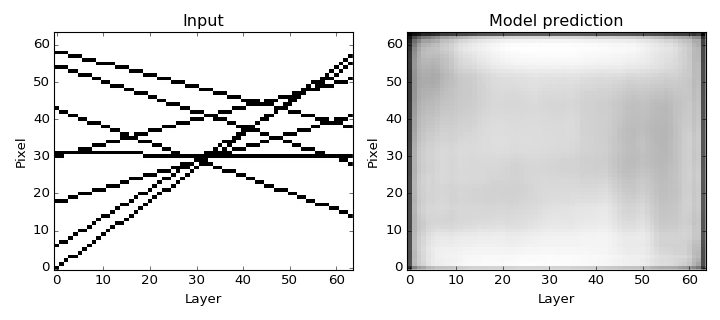

In [43]:
num_test = 1
det_shape = (64, 64)
num_tracks = 8
test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
test_pred = model.predict(test_events)
draw_2d_input_and_pred(test_events[0], test_pred[0], cmap='gray_r');

So we were able to make our prediction with Keras, and although it is bad we'll be able to compare our prediction more acturately than just by looking at the plot.

Now let's see how our prediction compares. But first let's look at some intermediate outputs produced by Keras to make sure all of our methods are working correctly.

In [96]:
#input layer
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
#reshape
get_2nd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
#convolution
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
#pooling
get_5th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])
#upsampling
get_14th_layer_output = K.function([model.layers[0].input],
                                  [model.layers[13].output])

print("Input layer output:\n", get_1st_layer_output([test_events])[0])
print("First reshape layer output:\n", get_2nd_layer_output([test_events])[0])
print("First convolution layer output:\n", get_3rd_layer_output([test_events])[0])
print("IMPORTANT STUFF HERE")
the_stuff = get_3rd_layer_output([test_events])[0]
print (len(the_stuff[0]))
print(len(the_stuff[0][0]))
print(len(the_stuff[0][0][0]))
print(the_stuff[0][0][0])
print("First pooling layer output:\n", get_5th_layer_output([test_events])[0])
print("First upsampling layer output:\n", get_14th_layer_output([test_events])[0])

Input layer output:
 [[[ 1.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
First reshape layer output:
 [[[[ 1.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 1.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 1.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]]
First convolution layer output:
 [[[[ 0.07120059  0.          0.06235151 ...,  0.38626328  0.          0.        ]
   [ 0.01185165  0.01045809  0.         ...,  0.16213477  0.16970116  0.        ]
   [ 0.22669348  0.          0.15355559 ...,  0.00616214  0.15337303
     0.14084044]
   ..., 
   [ 0.          0.00201033  0.         ...,  0.007

In [189]:
pred_input = test_events
for layer in model.layers:
    layer_type = get_layer_type(layer)
    print("Performing forwards pass on a(n)", layer_type, "layer")
    print("Input matrix:", pred_input)
    layer_config = layer.get_config()
    #TODO - check if the item exists in layer_config, have default set if not
    if (layer_type == 'convolution2d'):
        pred_input = convolution_2d(pred_input, layer.get_weights(), 1, padding='same') #going to assume stride = 1 for now, TODO, fix this
        if layer_config['activation'] == 'relu':
            pred_input = relu(pred_input)
    if (layer_type == 'maxpooling2d'):
        pred_input = max_pool_2d(pred_input, layer_config['pool_size'][0], layer_config['strides'][0], padding='valid')
    if (layer_type == 'reshape'):
        pred_input = reshape(pred_input, layer_config['target_shape']) ##TODO##
    if (layer_type == 'upsampling2d'):
        pred_input = upsampling_2d(pred_input, layer_config['size'][0]) ##TODO##
    print("Output matrix:", pred_input)

Performing forwards pass on a(n) input layer
Input matrix: [[[ 1.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
Output matrix: [[[ 1.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
Performing forwards pass on a(n) reshape layer
Input matrix: [[[ 1.  0.  0. ...,  0.  0.  0.]
  [ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
Output matrix: [[[[ 1.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 1.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 1.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [[ 0.]
   [ 0.]
   [ 

ValueError: setting an array element with a sequence.

In [160]:
import numpy as np
test_inp = np.reshape(test_events, (1,) + det_shape + (1,))
#wrapping_array = np.ndarray(shape=(1))
#wrapping_array[0] = test_inp
print(test_inp)

[[[[ 1.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 1.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 1.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]]


In [165]:
padded_inp = np.pad(test_inp, ((0, 0), (1, 1), (1, 1), (0, 0)), 'constant')
#print(padded_inp)
print(padded_inp.T)
print(padded_inp.T.T)
print(len(padded_inp))
print(len(padded_inp[0]))
print(len(padded_inp[0][0]))

[[[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 1.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 1.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]]
[[[[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 1.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 1.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  ..., 
  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ..., 
   [ 0.]
   [ 0.]
   [ 0.]]]]
1
66
66


In [103]:
test_weights = model.layers[2].get_weights()[0]
print(test_weights)
print("==========================================================")
print(test_weights.T)
print("==========================================================")
print(np.reshape(test_weights, (8, 3, 3)))

[[[[ 0.14093246  0.23556004  0.27134269  0.13698472  0.05886189  0.1962235
    -0.0845307  -0.08991408]]

  [[-0.0986115   0.27144131  0.25466871  0.10097855 -0.03763162 -0.11013556
    -0.18407133 -0.17479232]]

  [[ 0.12828138 -0.11564524  0.24410011 -0.10259331 -0.26800483  0.20492868
    -0.05423663 -0.18567941]]]


 [[[ 0.23877643 -0.10887155 -0.06376124 -0.03432018  0.27223179 -0.02733315
     0.17824136 -0.1519336 ]]

  [[ 0.04373677 -0.24849443  0.20202605 -0.05283171 -0.17421795  0.10978606
    -0.15400499 -0.24529734]]

  [[ 0.13341653  0.07116028  0.26137853 -0.21171543 -0.01172216 -0.16778478
    -0.05246067  0.14634579]]]


 [[[ 0.23261276 -0.11384468  0.16005442  0.19646883  0.1156688  -0.00149744
     0.15098765  0.13052893]]

  [[-0.2210055   0.11731931 -0.17653897 -0.17691913 -0.23106767  0.18180832
    -0.01092557  0.13290198]]

  [[ 0.0333831   0.032762   -0.13317572 -0.21587099  0.24495734  0.26881763
    -0.2122329   0.03910512]]]]
[[[[ 0.14093246  0.23877643  0.23

In [110]:
test_filter_double_transpose = test_weights.T[2][0].T
test_filter_single_transpose = test_weights.T[2][0]
print(test_filter_double_transpose)
print(test_filter_single_transpose)

[[ 0.27134269  0.25466871  0.24410011]
 [-0.06376124  0.20202605  0.26137853]
 [ 0.16005442 -0.17653897 -0.13317572]]
[[ 0.27134269 -0.06376124  0.16005442]
 [ 0.25466871  0.20202605 -0.17653897]
 [ 0.24410011  0.26137853 -0.13317572]]


In [89]:
np.convolve(padded_inp[0], test_filter_single_transpose, 'valid')

ValueError: object too deep for desired array

In [91]:
print(padded_inp[0], padded_inp[1], padded_inp[2])

[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] [[ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0

In [100]:
#the bias
test_bias = model.layers[2].get_weights()[1]
print(test_bias)

[-0.00591928  0.00201033 -0.00649883  0.00461192  0.00251468  0.00765959
  0.00238537  0.01031151]


In [131]:
print(model.layers[2].get_config())

{'W_constraint': None, 'b_constraint': None, 'name': u'convolution2d_1', 'activity_regularizer': None, 'trainable': True, 'dim_ordering': u'tf', 'nb_col': 3, 'subsample': (1, 1), 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 8, 'b_regularizer': None, 'W_regularizer': None, 'nb_row': 3, 'activation': 'relu', 'border_mode': u'same'}


In [146]:
print(model.layers[3].get_weights()[1])

[ 0.00488676  0.00824209  0.00782068  0.00535196  0.00131215  0.00394723
 -0.00460735 -0.00654326]


In [179]:
print(model.layers[13].get_config())
print(model.layers[13].get_weights())

{'trainable': True, 'name': u'upsampling2d_1', 'size': (2, 2)}
[]


In [178]:
get_12th_layer_output = K.function([model.layers[0].input],
                                   [model.layers[12].output])
get_13th_layer_output = K.function([model.layers[0].input],
                                   [model.layers[13].output])

print("Upsampling input:\n", get_12th_layer_output([test_events])[0])
print("Upsampling output:\n", get_13th_layer_output([test_events])[0])

Upsampling input:
 [[[[ 0.          0.21567081  0.15782529 ...,  0.36450961  0.08344018
     0.05429101]
   [ 0.          0.30041534  0.21286699 ...,  0.25540304  0.14212582
     0.16427495]
   [ 0.          0.44451395  0.1940335  ...,  0.23750988  0.11899392
     0.18591663]
   ..., 
   [ 0.01971943  0.53771186  0.17805845 ...,  0.05060805  0.08205797
     0.26105785]
   [ 0.03828134  0.48474368  0.17131482 ...,  0.          0.07397708
     0.26890099]
   [ 0.07042864  0.31560123  0.14817819 ...,  0.          0.02583017
     0.30223069]]

  [[ 0.          0.49478623  0.3725881  ...,  0.44545272  0.          0.09340826]
   [ 0.          0.60832691  0.411102   ...,  0.28314304  0.          0.26813155]
   [ 0.          0.71599722  0.3770842  ...,  0.14943208  0.          0.25478122]
   ..., 
   [ 0.          0.82997787  0.32379103 ...,  0.          0.          0.31921104]
   [ 0.04974138  0.6981526   0.30705023 ...,  0.          0.          0.32511127]
   [ 0.14879301  0.39692143  0.1281